<a href="https://colab.research.google.com/github/vpapadiotis/Evangelos_Papadiotis_Data_Projects/blob/main/copy_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing pytorch lightning framework

In [ ]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts

# Importing necessary libraries

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
from wordcloud import WordCloud, STOPWORDS
import pandas as pd

# Connect to google drive in order to have access to the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the dataset

In [ ]:
root_path = "/content/drive/MyDrive/ml-1m"
#Load the users data
users = pd.read_csv(f"{root_path}/users.dat", sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
#Load the ratings data
ratings = pd.read_csv(f"{root_path}/ratings.dat", sep='::', names=['userId', 'movieId', 'rating', 'timestamp'], engine='python')
#Load the movies data
movies = pd.read_csv(f"{root_path}/movies.dat", sep='::', names=['movieId', 'title', 'genres'], engine='python', encoding='latin-1')
#Merge the ratings and movies data
data = pd.merge(ratings, movies, on='movieId')

<ipython-input-5-3ace688c416a>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(f"{root_path}/users.dat", sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])


FileNotFoundError: ignored

In [ ]:
data

,userId,movieId,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,White Boys (1999),Drama
1000207,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western


In [ ]:
len(data['title'].unique())

3706

# Visualize dataframes

In [ ]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Data Analysis

In [ ]:
#Calculate the number of users, movies of the data
n_users = len(data.userId.unique())
print(f'Number of users: {n_users}')
n_movies = len(data.movieId.unique())
print(f'Number of movies: {n_movies}')
#Calculating the average rating and sparsity for the movies total
avg_rating = data.rating.mean()
print(f'Average rating: {avg_rating:.2f}')
sparsity = 1 - len(data) / (n_users * n_movies)
print(f'Sparsity: {sparsity:.6f}')

Number of users: 6040
Number of movies: 3706
Average rating: 3.58
Sparsity: 0.955316


<Axes: xlabel='rating', ylabel='Count'>

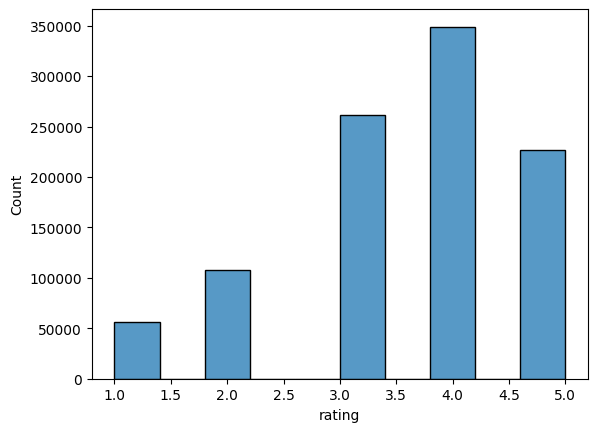

In [ ]:
#Check the distribution of ratings
sns.histplot(data = ratings, x = 'rating', bins = 10)

<Axes: xlabel='age', ylabel='Count'>

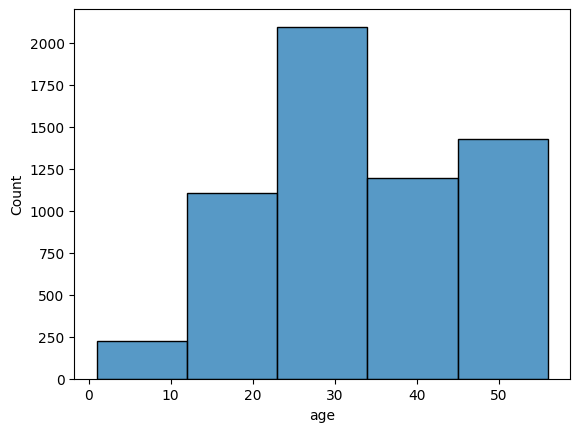

In [ ]:
#Check users' age distribution
sns.histplot(data=users, x='age', bins=5)

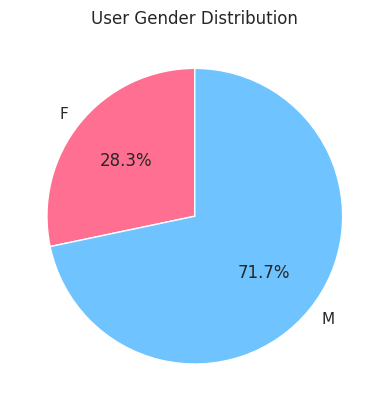

In [ ]:
#Check users' gender distribution
gender_count = users.groupby("gender")["user_id"].count().reset_index()
#Define custom colors
colors = ["#FF6F91", "#6FC3FF"]
#Set seaborn style
sns.set(style="white")
#Create pie plot
plt.pie(gender_count["user_id"], labels=gender_count["gender"], colors=colors,
        autopct='%1.1f%%', startangle=90)
#Add title
plt.title("User Gender Distribution")
#Show plot
plt.show()

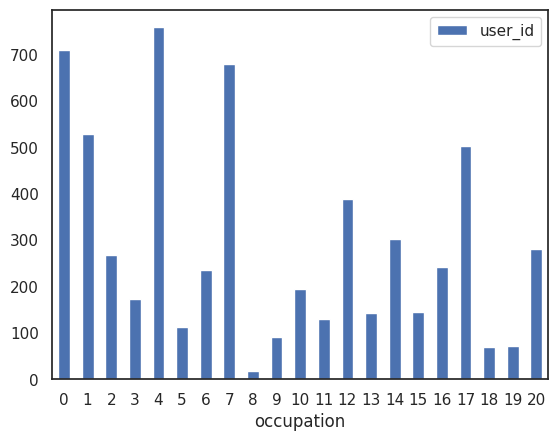

In [ ]:
#Check users' occupation distribution
users.groupby("occupation")["user_id"].count().reset_index().plot.bar(x="occupation", y="user_id")
#Rotate x-axis labels
plt.xticks(rotation=0)
plt.show()

<Axes: ylabel='Frequency'>

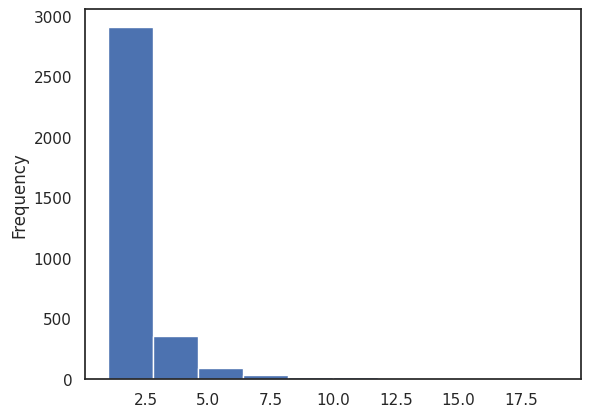

In [ ]:
#Check users' zip code distribution
users.groupby("zip_code")["user_id"].count().reset_index()["user_id"].plot.hist()

In [ ]:
#Define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords:
            if pd.notnull(s): keyword_count[s] += 1
    #Convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
#Make census of the genres:
genre_labels = set()
for s in data['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [ ]:
#Counting how many times each of genres occur:
keyword_occurences, dum = count_word(data, 'genres', genre_labels)
keyword_occurences

[['Comedy', 356580],
 ['Drama', 354529],
 ['Action', 257457],
 ['Thriller', 189680],
 ['Sci-Fi', 157294],
 ['Romance', 147523],
 ['Adventure', 133953],
 ['Crime', 79541],
 ['Horror', 76386],
 ["Children's", 72186],
 ['War', 68527],
 ['Animation', 43293],
 ['Musical', 41533],
 ['Mystery', 40178],
 ['Fantasy', 36301],
 ['Western', 20683],
 ['Film-Noir', 18261],
 ['Documentary', 7910]]

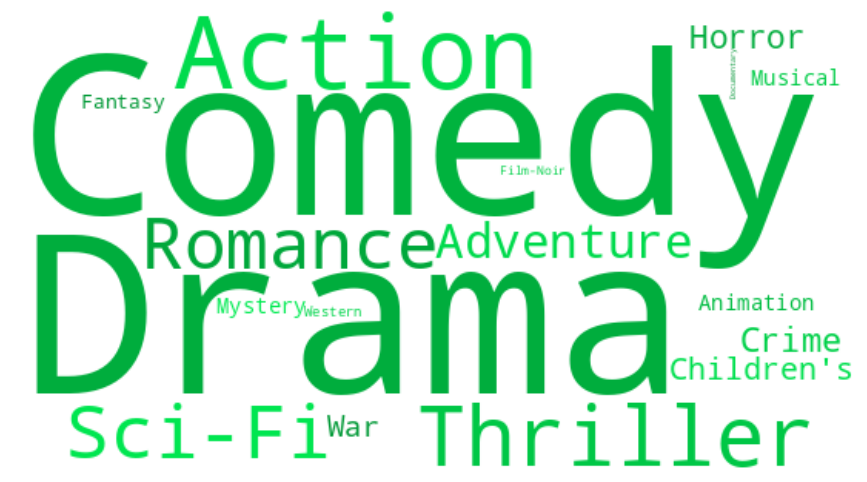

In [ ]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white',
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Split the genres column into a list of genres
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
# Create a dictionary to store the count of movies for each genre
genre_count = {}
for genres in movies['genres']:
    for genre in genres:
        if genre not in genre_count:
            genre_count[genre] = 1
        else:
            genre_count[genre] += 1

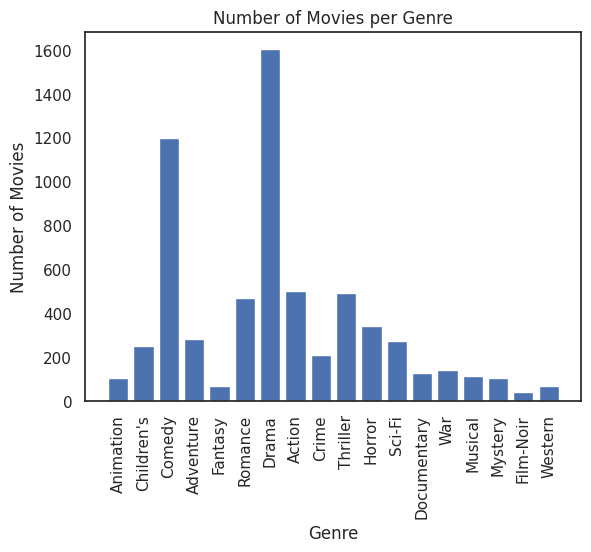

In [ ]:
# Create a bar plot
plt.bar(x=genre_count.keys(), height=genre_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.show()

In [ ]:
#Fix the movies frame to default
movies = pd.read_csv(f"{root_path}/movies.dat", sep='::', names=['movieId', 'title', 'genres'], engine='python', encoding='latin-1')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


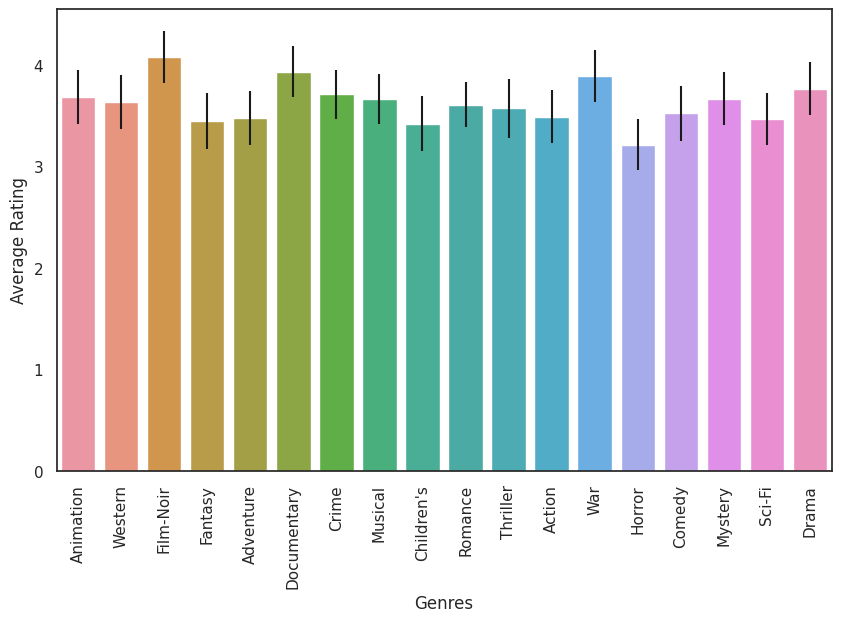

In [ ]:
# Split the genres column
genres_split = movies['genres'].str.split('|', expand=True)
# Concatenate the movie id and genres dataframes
movies_with_genres = pd.concat([movies['movieId'], genres_split], axis=1)
# Melt the dataframe to make it tidy
movies_with_genres_melted = pd.melt(movies_with_genres, id_vars='movieId', value_name='genre')
# Merge the ratings and genres dataframes
ratings_with_genres = pd.merge(ratings, movies_with_genres_melted, on='movieId')
# Calculate the average rating and standard deviation for each unique genre
genres_avg_rating = ratings_with_genres.groupby('genre')['rating'].agg(['mean', 'std'])
genres_avg_rating = genres_avg_rating.reset_index()
# Define the order of the genres to random
genre_order = genres_avg_rating['genre'].unique()
np.random.shuffle(genre_order)
# Create the barplot
plt.figure(figsize=(10,6))
sns.barplot(data=genres_avg_rating, x='genre', y='mean', order=genre_order,
            yerr=genres_avg_rating['std']/np.sqrt(genres_avg_rating['std'].shape[0]))
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
# Group the ratings by movie and count the number of ratings per movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count()
# Get the 10 most rated movies
most_rated_movies = movie_ratings_count.sort_values(ascending=False)[:10]
# Merge the most rated movies with their titles
most_rated_movies_titles = pd.merge(most_rated_movies, movies, on='movieId')
# Print the result
print(most_rated_movies_titles[['title', 'rating']])

                                               title  rating
0                             American Beauty (1999)    3428
1          Star Wars: Episode IV - A New Hope (1977)    2991
2  Star Wars: Episode V - The Empire Strikes Back...    2990
3  Star Wars: Episode VI - Return of the Jedi (1983)    2883
4                               Jurassic Park (1993)    2672
5                         Saving Private Ryan (1998)    2653
6                  Terminator 2: Judgment Day (1991)    2649
7                                 Matrix, The (1999)    2590
8                          Back to the Future (1985)    2583
9                   Silence of the Lambs, The (1991)    2578


In [ ]:
#Order the movies from less to most ratings count
least_rated_movies = ratings.groupby('movieId').size().sort_values(ascending=True)[:10]
movies.loc[least_rated_movies.index][['title']].join(least_rated_movies.rename('rating_count'))

,title,rating_count
movieId,,
402,Federal Hill (1994),1
2214,"Sheltering Sky, The (1990)",1
3382,Guess Who's Coming to Dinner (1967),1
2217,"Fiendish Plot of Dr. Fu Manchu, The (1980)",1
2218,Them! (1954),1
641,Courage Under Fire (1996),1
642,Mission: Impossible (1996),1
3656,American Pop (1981),1
2226,"Impostors, The (1998)",1


In [ ]:
from scipy.stats import ks_2samp
#Group ratings data by movie
movie_ratings = ratings.groupby('movieId')['rating'].apply(list)
#Create empty list to hold groups of movies with similar rating distributions
similar_movies = []
#Loop over all pairs of movies and perform KS test
for i, movie1 in movie_ratings.iteritems():
    for j, movie2 in movie_ratings.iteritems():
        if i < j:
          #Perform KS test
          ks_stat, p_value = ks_2samp(movie1, movie2)
            if p_value >= 0.01:
                #If p-value is above threshold, add movies to same group
                for group in similar_movies:
                    if i in group or j in group:
                        group.add(i)
                        group.add(j)
                        break
                else:
                    #If no existing group found, create new group
                    similar_movies.append({i, j})
#Print list of similar movie groups
print(similar_movies)
print()

In [ ]:
#First similar movies list sample ids
sample1 = [1, 1193]
#Second similar movies list sample ids
sample2 = [2, 10]
#Third similar movies list sample ids
sample3 = [6, 16]
#Create a single lIst that includes the upper samples
samples_list = sample1 + sample2 + sample3
print(samples_list)

[1, 1193, 2, 10, 6, 16]


In [ ]:
num_ratings = ratings[ratings['movieId'] == 16]['movieId'].value_counts().values[0]
num_ratings

682

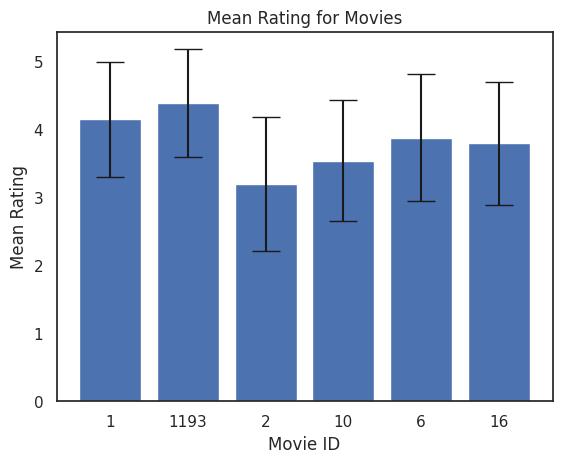

In [ ]:
# Create empty lists to store means and standard deviations
mean_ratings = []
std_ratings = []
#Minimum number of ratings required to calculate mean and standard deviation
min_ratings = 50
#Loop through movie IDs and calculate mean and standard deviation of ratings
for movie_id in samples_list:
    movie_ratings = data[data['movieId'] == movie_id]['rating']
    if len(movie_ratings) >= min_ratings:
        mean_rating = movie_ratings.mean()
        std_rating = movie_ratings.std()
        mean_ratings.append(mean_rating)
        std_ratings.append(std_rating)
#Create a barplot with error bars using Matplotlib
plt.bar(range(len(mean_ratings)), mean_ratings, yerr=std_ratings, capsize=10)
#Add axis labels and title
plt.xticks(range(len(mean_ratings)), samples_list)
plt.xlabel('Movie ID')
plt.ylabel('Mean Rating')
plt.title('Mean Rating for Movies')
#Show the plot
plt.show()

In [ ]:
#Calculate the total amount of ratings given by each user
user_engagement = ratings.groupby("userId")["rating"].sum().reset_index()
#Normalize the user engagement values using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_engagement["engagement"] = scaler.fit_transform(user_engagement[["rating"]])
user_engagement = user_engagement.rename(columns={"userId": "user_id"})
#Merge the user engagement with the users dataframe
users = pd.merge(users, user_engagement[["user_id", "engagement"]], on="user_id")

In [ ]:
users.head(10)

,user_id,gender,age,occupation,zip_code,engagement
0,1,F,1,10,48067,0.021055
1,2,M,56,16,70072,0.052516
2,3,M,25,15,55117,0.018240
3,4,M,45,7,02460,0.004652
4,5,M,25,20,55455,0.070143
5,6,F,50,9,55117,0.027788
6,7,M,35,1,06810,0.010283
7,8,M,25,12,11413,0.059983
8,9,M,25,17,61614,0.042355
9,10,F,35,1,95370,0.195862


In [ ]:
#Find maximum engagement user
max_engagement_user = user_engagement.sort_values('engagement', ascending=False).iloc[0]
max_engagement_user

user_id       4169.0
rating        8219.0
engagement       1.0
Name: 4168, dtype: float64

In [ ]:
#Find minimum engagement user
min_engagement_user = user_engagement.sort_values('engagement', ascending=True).iloc[0]
min_engagement_user

user_id       4636.0
rating          50.0
engagement       0.0
Name: 4635, dtype: float64

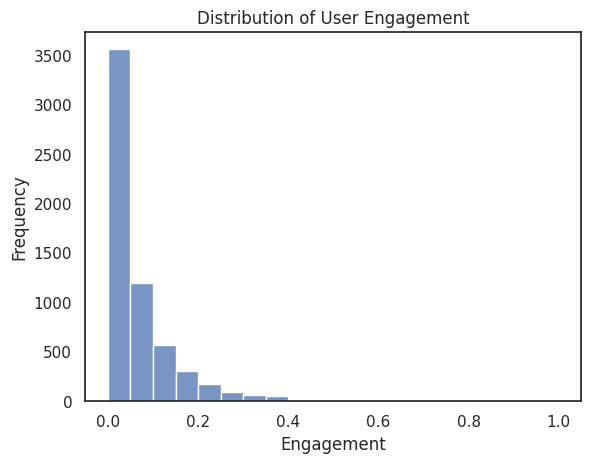

In [ ]:
#Create a histogram of the engagement values
sns.histplot(data=user_engagement, x="engagement", bins=20)
#Add plot labels
plt.xlabel("Engagement")
plt.ylabel("Frequency")
plt.title("Distribution of User Engagement")
#Display the plot
plt.show()

<ipython-input-36-cc59f6ae9ef1>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='age', y='engagement', data=users, ci='sd')


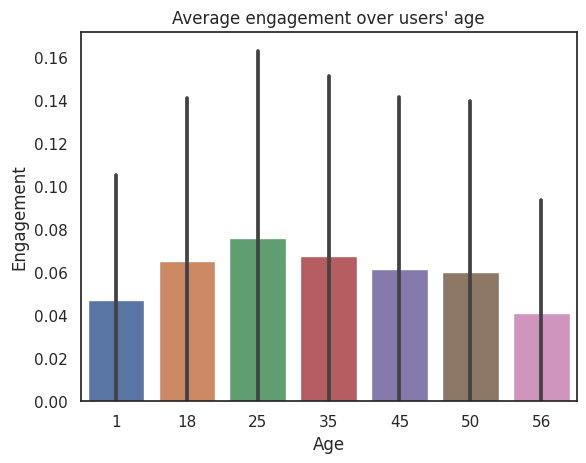

In [ ]:
#Draw a barplot that contains mean engagement and users' age, and also apply standard deviation
sns.barplot(x='age', y='engagement', data=users, ci='sd')
#Define the error bars limits
plt.ylim(bottom=0)
#Edit plot labels
plt.xlabel('Age')
plt.ylabel('Engagement')
plt.title("Average engagement over users' age")
#Show plot
plt.show()

<ipython-input-37-98dbe7ddd16f>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='occupation', y='engagement', data=users, ci='sd')


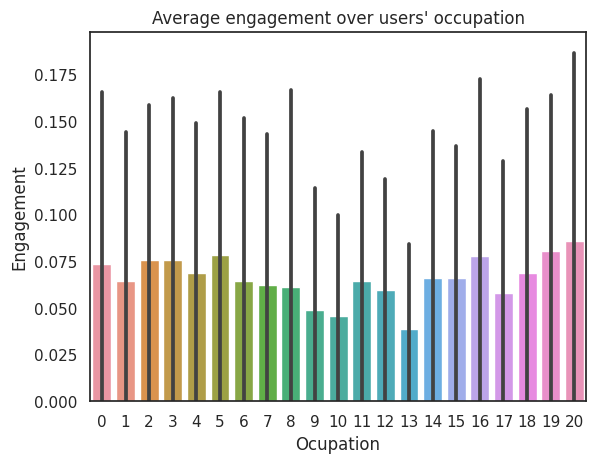

In [ ]:
#Draw a barplot that contains mean engagement and users' occupation, and also apply standard deviation
sns.barplot(x='occupation', y='engagement', data=users, ci='sd')
#Define the error bars limits
plt.ylim(bottom=0)
#Edit plot labels
plt.xlabel('Ocupation')
plt.ylabel('Engagement')
plt.title("Average engagement over users' occupation")
#Show plot
plt.show()

<ipython-input-38-d827b322931a>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='gender', y='engagement', data=users, ci='sd')


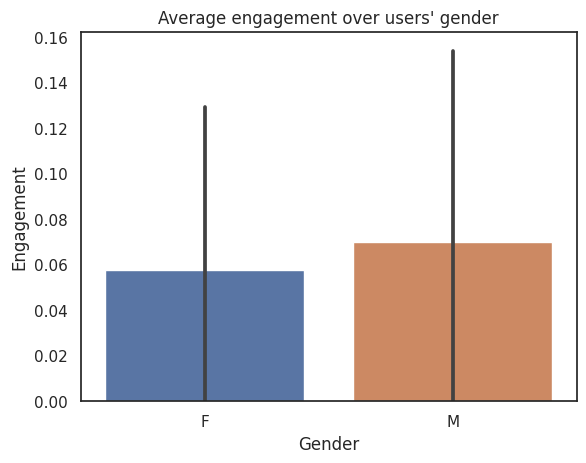

In [ ]:
#Draw a barplot that contains mean engagement and users' gender, and also apply standard deviation
sns.barplot(x='gender', y='engagement', data=users, ci='sd')
#Define the error bars limits
plt.ylim(bottom=0)
#Edit plot labels
plt.xlabel('Gender')
plt.ylabel('Engagement')
plt.title("Average engagement over users' gender")
#Show plot
plt.show()

In [ ]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s').dt.date
data['date'] = pd.to_datetime(data['date']) #convert to datetime object
data['day_of_week'] = data['date'].dt.day_name()
data.head()

,userId,movieId,rating,timestamp,title,genres,date,day_of_week
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-31,Sunday
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-31,Sunday
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday


Text(0, 0.5, 'Total Ratings')

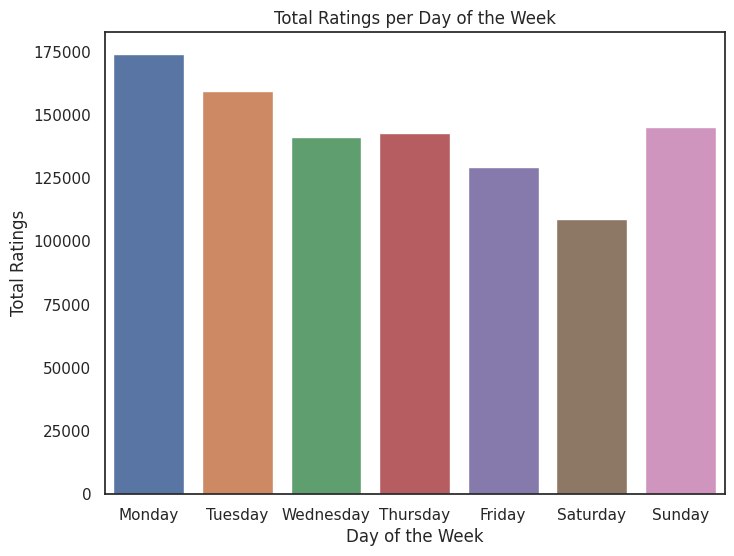

In [ ]:
# Count the total number of ratings for each day of the week
total_ratings = data.groupby('day_of_week')['rating'].count()
# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reindex the total_ratings Series to match the desired order
total_ratings = total_ratings.reindex(day_order)
# Create the barplot
plt.figure(figsize=(8,6))
sns.barplot(x=total_ratings.index, y=total_ratings.values)
# Set the plot title and labels
plt.title('Total Ratings per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Ratings')

      Day  Mean Rating  Standard Deviation
   Friday     3.602590            1.099109
   Monday     3.600330            1.120319
 Saturday     3.603319            1.102751
   Sunday     3.553760            1.126180
 Thursday     3.569092            1.131043
  Tuesday     3.577785            1.110974
Wednesday     3.567844            1.122780



<ipython-input-41-9a39c7d16929>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='rating', data=mean_rating,


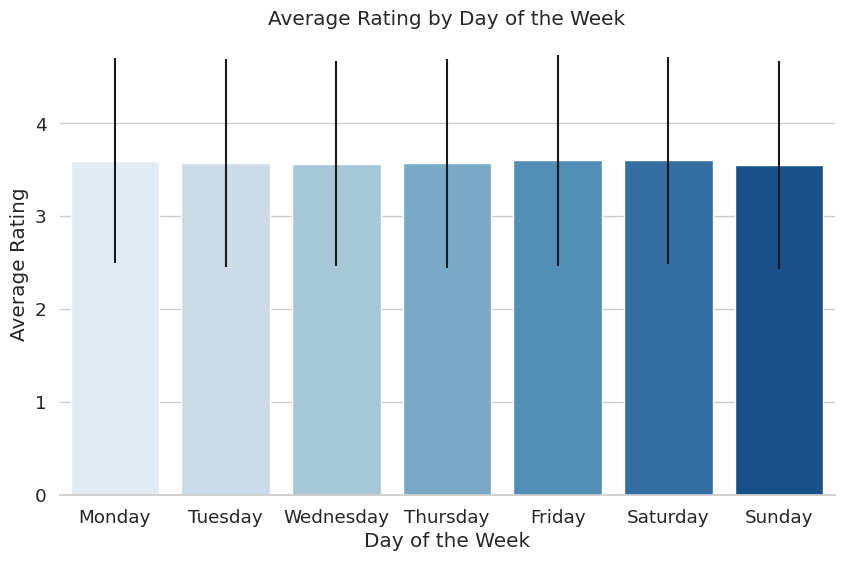

In [ ]:
# Calculate the mean rating and standard deviation for each day of the week
mean_rating = data.groupby('day_of_week')['rating'].mean().reset_index()
std_rating = data.groupby('day_of_week')['rating'].std().reset_index()
# Combine mean and std into a new DataFrame
rating_stats = pd.merge(mean_rating, std_rating, on='day_of_week')
rating_stats.columns = ['Day', 'Mean Rating', 'Standard Deviation']
# Display as a table
print(rating_stats.to_string(index=False))
print()
# Create the barplot with error bars
sns.set(style='whitegrid', font_scale=1.2, rc={'figure.figsize':(10,6)})
sns.barplot(x='day_of_week', y='rating', data=mean_rating,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            ci=None, capsize=0.1, errwidth=1.5, palette='Blues',
            yerr=std_rating['rating'])
sns.despine(left=True)
plt.xlabel('Day of the Week')
plt.ylabel('Average Rating')
plt.title('Average Rating by Day of the Week')
plt.show()

In [ ]:
#Printing unique genres. This is also given in the dataset description file
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
print(genres_unique)

          genre
0     Animation
1    Children's
2        Comedy
3     Adventure
4       Fantasy
5       Romance
6         Drama
7        Action
8         Crime
9      Thriller
10       Horror
11       Sci-Fi
12  Documentary
13          War
14      Musical
15      Mystery
16    Film-Noir
17      Western


In [ ]:
movies['release_year'] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)

In [ ]:
movies['release_year'] = pd.to_datetime(movies.release_year, format='%Y')
movies['release_year'] = movies.release_year.dt.year
movies['title'] = movies.title.str[:-7]

In [ ]:
movies_temp = movies.join(movies.genres.str.get_dummies().astype(bool))
movies_temp.drop('genres', inplace=True, axis=1)
movies_temp

,movieId,title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995,False,True,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,Father of the Bride Part II,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,2000,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3879,3949,Requiem for a Dream,2000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3880,3950,Tigerland,2000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3881,3951,Two Family House,2000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


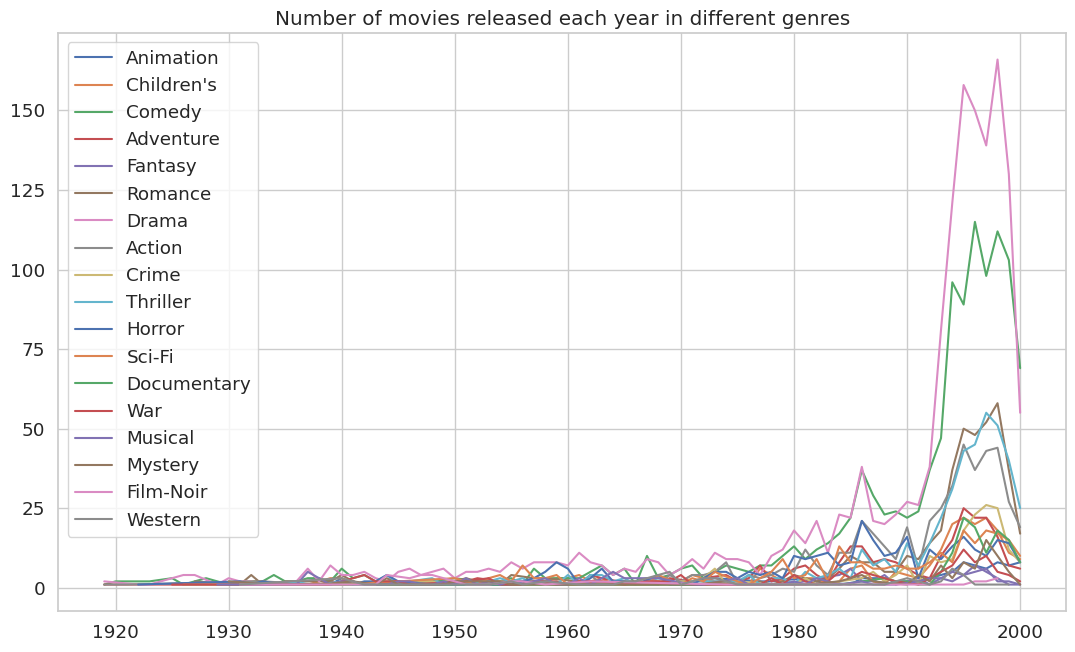

In [ ]:
plt.figure(figsize=(13,7.5))
for genre in genres_unique.genre:
    df_temp = movies_temp[movies_temp[genre]==True][['release_year', 'movieId']]
    df_temp = df_temp.groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'movieId':'movies'})
    plt.plot(df_temp['year'], df_temp['movies'], label=genre)
plt.title('Number of movies released each year in different genres')
plt.legend()
plt.show()

# Feature Engineering


In [ ]:
data = data.join(users.set_index("user_id"), on="userId")

In [ ]:
data.head()

,userId,movieId,rating,timestamp,title,genres,date,day_of_week,gender,age,occupation,zip_code,engagement
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-31,Sunday,F,1,10,48067,0.021055
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-31,Sunday,M,56,16,70072,0.052516
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday,M,25,12,32793,0.004652
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday,M,25,7,22903,0.075652
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama,2000-12-30,Saturday,M,50,1,95350,0.099155


In [ ]:
# Merge the ratings and movies DataFrames
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings

,userId,movieId,rating,timestamp,title,genres,release_year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,Modulations,Documentary,1998
1000205,5675,2703,3,976029116,Broken Vessels,Drama,1998
1000206,5780,2845,1,958153068,White Boys,Drama,1999
1000207,5851,3607,5,957756608,One Little Indian,Comedy|Drama|Western,1973


In [ ]:
# Rename the 'userId' column in movie_ratings to match the column name in users
movie_ratings.rename(columns={'userId': 'user_id'}, inplace=True)

In [ ]:
# Merge the movie_ratings and users DataFrames
merged_df = pd.merge(movie_ratings, users, on='user_id')

# Split genres into separate columns
genre_columns = merged_df['genres'].str.get_dummies('|')

# Concatenate the original DataFrame with the new genre columns
merged_df = pd.concat([merged_df, genre_columns], axis=1)

# Drop the original 'genres' column and any other unwanted columns
columns_to_drop = ['genres']  # Adjust this list as needed
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)


In [ ]:
merged_df

,user_id,movieId,rating,timestamp,title,release_year,gender,age,occupation,zip_code,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,1975,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,978302109,James and the Giant Peach,1996,F,1,10,48067,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3,978301968,My Fair Lady,1964,F,1,10,48067,...,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,978300275,Erin Brockovich,2000,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,978824291,"Bug's Life, A",1998,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,4211,3791,2,965319075,Footloose,1984,M,45,5,77662,...,0,0,0,0,0,0,0,0,0,0
1000205,4211,3806,3,965319138,MacKenna's Gold,1969,M,45,5,77662,...,0,0,0,0,0,0,0,0,0,1
1000206,4211,3840,4,965319197,Pumpkinhead,1988,M,45,5,77662,...,0,0,1,0,0,0,0,0,0,0
1000207,4211,3766,2,965319138,Missing in Action,1984,M,45,5,77662,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
merged_df.columns

Index(['user_id', 'movieId', 'rating', 'timestamp', 'title', 'release_year',
       'gender', 'age', 'occupation', 'zip_code', 'engagement', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [ ]:
data = merged_df

In [ ]:
cols=["user_id", "movieId", "rating", "timestamp", "gender", "age", "occupation","engagement", "zip_code",
       "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
       "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
       "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
data_features = data[cols]

In [ ]:
cols_categories = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

data_features['category_one_hot'] = data_features[cols_categories].apply(list, axis=1)

data_features = data_features.drop(columns=cols_categories)

<ipython-input-56-2c087dd75866>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['category_one_hot'] = data_features[cols_categories].apply(list, axis=1)


In [ ]:
data_features.head()

,user_id,movieId,rating,timestamp,gender,age,occupation,engagement,zip_code,category_one_hot
0,1,1193,5,978300760,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,661,3,978302109,F,1,10,0.021055,48067,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,1,914,3,978301968,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,1,3408,4,978300275,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,2355,5,978824291,F,1,10,0.021055,48067,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
from sklearn import preprocessing
gender_le = preprocessing.LabelEncoder()
gender_one_hot = preprocessing.OneHotEncoder()

data_features["gender_encoded"] = gender_le.fit_transform(data_features["gender"])

data_features['gender_one_hot'] = gender_one_hot.fit_transform(data_features["gender_encoded"].values.reshape(-1,1)).toarray().tolist()

In [ ]:
data_features.head()

,user_id,movieId,rating,timestamp,gender,age,occupation,engagement,zip_code,category_one_hot,gender_encoded,gender_one_hot
0,1,1193,5,978300760,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,"[1.0, 0.0]"
1,1,661,3,978302109,F,1,10,0.021055,48067,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0,"[1.0, 0.0]"
2,1,914,3,978301968,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0,"[1.0, 0.0]"
3,1,3408,4,978300275,F,1,10,0.021055,48067,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,"[1.0, 0.0]"
4,1,2355,5,978824291,F,1,10,0.021055,48067,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[1.0, 0.0]"


In [ ]:
occupation_le = preprocessing.LabelEncoder()
occupation_one_hot = preprocessing.OneHotEncoder()
data_features["occupation_encoded"] = occupation_le.fit_transform(data_features["occupation"])
data_features['occupation_one_hot'] = occupation_one_hot.fit_transform(data_features["occupation_encoded"].values.reshape(-1,1)).toarray().tolist()

In [ ]:
age_le = preprocessing.MinMaxScaler()
data_features["age_scaled"] = age_le.fit_transform(data_features["age"].values.reshape(-1,1))

In [ ]:
rating_sc = preprocessing.MinMaxScaler()
data_features["rating_scaled"] = rating_sc.fit_transform(data_features["rating"].values.reshape(-1,1))

In [ ]:
# Extract the timestamp column and reshape to a 2D array
temp = data_features['timestamp'].values.reshape(-1, 1)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit the scaler to the data and transform the timestamps
timestamp_scaled = scaler.fit_transform(temp)
# Replace the original timestamps in the DataFrame with the normalized values
data_features['timestamp_scaled'] = timestamp_scaled
# Display the DataFrame with the new normalized timestamp column
print(data_features)

In [ ]:
drop = ['timestamp']
data_features.drop(columns=drop, inplace=True)

In [ ]:
zip_code_le = preprocessing.LabelEncoder()
zip_code_one_hot = preprocessing.OneHotEncoder()
data_features["zip_code_encoded"] = zip_code_le.fit_transform(data_features["zip code"])
data_features['zip_code_one_hot'] = zip_code_one_hot.fit_transform(data_features["zip_code_encoded"].values.reshape(-1,1)).toarray().tolist()

In [ ]:
data_features

,Unnamed: 0,user_id,movie_id,rating_scaled,age_scaled,gender_one_hot,occupation_one_hot,zip_code_one_hot,timestamp_scaled
0,0,259,255,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000e+00
1,1,259,286,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.158531e-07
2,2,259,298,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.370443e-06
3,3,259,185,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.825034e-06
4,4,259,173,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.165204e-06
...,...,...,...,...,...,...,...,...,...
99995,99995,729,689,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99996,99996,729,313,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99997,99997,729,328,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99998,99998,729,748,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00


In [ ]:
cols_features=["user_id", "movieId", "rating_scaled", "timestamp", "age_scaled", "gender_one_hot","occupation_one_hot"]
data_features = data_features[cols_features]
data_features.drop()

In [ ]:
# data_features.to_csv('data_features.csv')
# !cp data_features.csv "drive/My Drive/"

# Modelling

In [ ]:
#!gdown 1hRTcCcgTIRd_slg58onVB2RaxQBeLhTK

In [ ]:
file_path = '/content/drive/MyDrive/data_features.csv'
data_features = pd.read_csv(file_path)

In [ ]:
data_features

,Unnamed: 0,user_id,movie_id,rating_scaled,age_scaled,gender_one_hot,occupation_one_hot,zip_code_one_hot,timestamp_scaled
0,0,259,255,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000e+00
1,1,259,286,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.158531e-07
2,2,259,298,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.370443e-06
3,3,259,185,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.825034e-06
4,4,259,173,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.165204e-06
...,...,...,...,...,...,...,...,...,...
99995,99995,729,689,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99996,99996,729,313,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99997,99997,729,328,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99998,99998,729,748,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00


In [ ]:
column_to_drop = ['Unnamed: 0']
data_features.drop(columns=column_to_drop, inplace=True)

In [ ]:
data_features

,user_id,movie_id,rating_scaled,age_scaled,gender_one_hot,occupation_one_hot,zip_code_one_hot,timestamp_scaled
0,259,255,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000e+00
1,259,286,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.158531e-07
2,259,298,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.370443e-06
3,259,185,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.825034e-06
4,259,173,0.75,0.212121,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.165204e-06
...,...,...,...,...,...,...,...,...
99995,729,689,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99996,729,313,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99997,729,328,0.50,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00
99998,729,748,0.75,0.181818,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000e+00


In [ ]:
def train_val_test_split(dataset, sequence_length):

    dataset, n_users, n_movies, user_interactions = preprocess_dataset(dataset, sequence_length)

    dataset_grouped = dataset.groupby('user_id').cumcount(ascending=False)
    print(dataset_grouped)
    train = dataset[dataset_grouped > 1]
    val = dataset[dataset_grouped == 1]
    test = dataset[dataset_grouped == 0]
    return train, val, test, n_users, n_movies, user_interactions

def preprocess_dataset(dataset, sequence_length):
    n_users = dataset['user_id'].nunique() + 1
    n_movies = dataset['movie_id'].nunique()

    def generate_sequences(x):
        movies_list = x.values
        result = []
        for i in range(len(movies_list) - 1):
            sequence = np.zeros(sequence_length, dtype=int) + n_movies
            start_index = max(0, i - sequence_length)
            end_index = i + 1
            for idx, movie in enumerate(reversed(movies_list[start_index:end_index])):
                sequence[sequence_length - 1 - idx] = int(movie)
            result.append((sequence, movies_list[i+1]))
        return result

    user_interactions = dataset.groupby('user_id')['movie_id'].apply(list).to_dict()


    dataset = dataset.groupby('user_id')['movie_id'].apply(generate_sequences).reset_index()
    dataset = dataset.explode('movie_id')
    dataset[['features','label']] =  pd.DataFrame(dataset['movie_id'].tolist(), index=dataset.index)

    return dataset[['user_id','features','label']], n_users, n_movies, user_interactions

In [ ]:
train, val, test, n_users, n_movies, train_u_i_dict = train_val_test_split(data_features, 500)

0      270
0      269
0      268
0      267
0      266
      ... 
942      4
942      3
942      2
942      1
942      0
Length: 99057, dtype: int64


In [ ]:
for user, interactions in train_u_i_dict.items():
    print("User:", user)
    print("Interactions:", interactions)
    print()

User: 1
Interactions: [168, 172, 165, 156, 166, 196, 187, 14, 250, 127, 181, 117, 109, 1, 246, 257, 248, 50, 249, 253, 262, 93, 224, 124, 19, 123, 137, 146, 7, 235, 15, 245, 260, 24, 264, 126, 237, 13, 25, 121, 251, 236, 240, 118, 130, 65, 190, 47, 31, 28, 114, 39, 52, 238, 199, 183, 11, 69, 161, 95, 60, 83, 179, 22, 98, 64, 135, 163, 26, 202, 89, 8, 214, 182, 48, 99, 160, 175, 192, 180, 128, 143, 185, 68, 55, 204, 56, 96, 81, 79, 151, 212, 23, 70, 84, 94, 197, 191, 184, 134, 207, 145, 188, 186, 97, 85, 36, 144, 159, 17, 174, 252, 105, 148, 108, 147, 220, 106, 243, 122, 107, 104, 247, 120, 45, 268, 267, 259, 261, 263, 10, 150, 234, 92, 71, 42, 176, 91, 193, 217, 177, 216, 194, 73, 59, 133, 41, 195, 218, 170, 213, 157, 223, 27, 227, 80, 231, 67, 119, 200, 4, 215, 164, 2, 206, 77, 53, 136, 46, 40, 153, 269, 254, 115, 173, 211, 229, 155, 203, 62, 90, 219, 167, 230, 35, 162, 61, 265, 112, 57, 49, 30, 233, 131, 152, 82, 141, 72, 33, 158, 198, 225, 113, 21, 149, 88, 101, 110, 103, 239, 34, 2

In [ ]:
train

,user_id,features,label
0,1,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",172
0,1,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",165
0,1,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",156
0,1,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",166
0,1,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",196
...,...,...,...
942,943,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",449
942,943,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",228
942,943,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",450
942,943,"[1682, 1682, 1682, 1682, 1682, 1682, 1682, 168...",227


In [ ]:
from numpy import double
from torch.utils.data import Dataset

class SequentialDataset(Dataset):
    def __init__(self, dataset, train):
        self.dataset = dataset
        if not train:
            self.dataset.sort_values(by='user_id',inplace=True)

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, index):
        row = self.dataset.iloc[index]
        user = int(row['user_id'])
        sequence = row['features']
        target = int(row['label'])
        return {'users':np.tile(user, len(sequence)), 'seqs': sequence, 'targets':target}


In [ ]:
trainLoader = DataLoader(SequentialDataset(train, True), batch_size=64, shuffle=True)
valLoader = DataLoader(SequentialDataset(val, False), batch_size=val.shape[0])
testLoader = DataLoader(SequentialDataset(test, False), batch_size=test.shape[0])

In [ ]:
for i, batch in enumerate(trainLoader):
  print (batch)
  break

{'users': tensor([[650, 650, 650,  ..., 650, 650, 650],
        [840, 840, 840,  ..., 840, 840, 840],
        [706, 706, 706,  ..., 706, 706, 706],
        ...,
        [661, 661, 661,  ..., 661, 661, 661],
        [234, 234, 234,  ..., 234, 234, 234],
        [ 13,  13,  13,  ...,  13,  13,  13]]), 'seqs': tensor([[1682, 1682, 1682,  ...,  499,  657,  479],
        [1682, 1682, 1682,  ...,  179,  521,  196],
        [1682, 1682, 1682,  ...,  125,  471,  117],
        ...,
        [1682, 1682, 1682,  ...,  514,  135,  174],
        [1682, 1682, 1682,  ...,  268,  313,  242],
        [1682, 1682, 1682,  ...,  320,  853,  844]]), 'targets': tensor([ 484,  514,  100,  148, 1089,  222,  225,  482,  155,  204,    7,  576,
         603,  378, 1132, 1020,   50, 1074,  172,   62,  597, 1101,  226,   50,
         237,   95,  429,  557,  625,   28,  356,  546, 1124,  568,  109,  433,
         566,  156, 1401,  188,   12, 1230,  234,  185,  289, 1228,  820,  693,
         168,  426,   79,  183,  

In [ ]:
#Pytorch-Lightning template
class MyModel(pl.LightningModule):

  def __init__(self):
    super(MyModel, self).__init__()

  def training_step(self, batch, batch_idx):
    pass

  def validation_step(self, batch, batch_idx):
    pass

  def test_step(self, batch, batch_idx):
    pass

  def configure_optimizers(self):
    pass

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class LSTM(pl.LightningModule):
    def __init__(self, n_users, n_movies, embed_dim, hidden_size, u_i_dict, k=5, lr=1e-3):
        super(LSTM, self).__init__()

        self.user_embedding = nn.Embedding(n_users, embed_dim)
        self.movie_embedding = nn.Embedding(n_movies + 1, embed_dim, padding_idx=n_movies)

        self.lstm = nn.LSTM(input_size=2 * embed_dim,
                            hidden_size=hidden_size,
                            num_layers=2,
                            bias=True,
                            batch_first=True,
                            dropout=0.3,
                            bidirectional=False,
                            proj_size=0)

        self.l1 = nn.Linear(in_features=hidden_size, out_features=hidden_size * 2)
        self.dropout = nn.Dropout(0.3)
        self.l2 = nn.Linear(in_features=hidden_size * 2, out_features=n_movies)
        self.leakyRelu = nn.LeakyReLU()  # Adding a LeakyReLU activation layer
        self.loss = nn.CrossEntropyLoss()
        self.lr = lr
        self.k = k
        self.mask = torch.ones(n_users, n_movies)
        for k, v in u_i_dict.items():
            self.mask[k][v] = 0

    def predict(self, batch):
        users = self.user_embedding(batch['users'])
        movies = self.movie_embedding(batch['seqs'])

        input = torch.cat((users, movies), dim=2)
        output, _ = self.lstm(input)
        output = self.l1(output)
        output = self.dropout(output)
        output = self.l2(output)
        output = self.leakyRelu(output)
        return output

    def training_step(self, batch, batch_idx):
        targets = batch['targets']
        output = self.predict(batch)
        loss = self.loss(output[:, -1, :], targets)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def evaluation(self, outputs, target):
        top_k_items = torch.argsort(outputs, dim=1, descending=True)[:, :self.k]
        print(top_k_items.size())
        ndcg_k = ndcg(top_k_items, target)
        hr_k = hr(top_k_items, target)
        return ndcg_k, hr_k

    def validation_step(self, batch, batch_idx):
        targets = batch['targets']
        output = self.predict(batch)
        print(output.size())
        print(output[:, -1, :].size())
        print(targets.size())

        loss = self.loss(output[:, -1, :], targets)

        ndcg_k, hr_k = self.evaluation(output[:, -1, :], targets)
        self.log('val_loss', loss)
        self.log('val_ndcg', ndcg_k)
        self.log('val_hr', hr_k)
        return loss

    def test_step(self, batch, batch_idx):
        targets = batch['targets']
        output = self.predict(batch)
        loss = self.loss(output[:, -1, :], targets)

        ndcg_k, hr_k = self.evaluation(output, targets)
        self.log('test_loss', loss)
        self.log('test_ndcg', ndcg_k)
        self.log('test_hr', hr_k)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        return optimizer


In [ ]:
import math
def ndcg(ratings, target):

    ndcg = []
    for i,v in enumerate(ratings):
        condition = v == target[i]
        indices = condition.nonzero()
        if indices.size()[0] > 0:
            ranking = indices[0][0]
            ndcg.append(1. / math.log(ranking.item() + 2,2))
        else:
            ndcg.append(0.)
    return sum(ndcg) / float(len(ndcg))

def hr(ratings, target):
    hr = []
    for i,v in enumerate(ratings):
        condition = v == target[i]
        indices = condition.nonzero()
        if indices.size()[0] > 0:
            hr.append(1.)
        else:
            hr.append(0.)
    return sum(hr) / float(len(hr))

In [ ]:
embed_dim = 128
hidden_dim= 256
max_movie_id = data_features['movie_id'].max()
n_movies = max_movie_id + 1  # Add 1 to include the maximum movie ID
model = LSTM(n_users, n_movies, embed_dim, hidden_dim, train_u_i_dict)
trainer = pl.Trainer(devices = 1, accelerator = "gpu", max_epochs=30, check_val_every_n_epoch=1)
trainer.fit(model, train_dataloaders=trainLoader, val_dataloaders=valLoader)
test = trainer.test(dataloaders = testLoader, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | user_embedding  | Embedding        | 120 K 
1 | movie_embedding | Embedding        | 215 K 
2 | lstm            | LSTM             | 1.1 M 
3 | l1              | Linear           | 131 K 
4 | dropout         | Dropout          | 0     
5 | l2              | Linear           | 863 K 
6 | leakyRelu       | LeakyReLU        | 0     
7 | loss            | CrossEntropyLoss | 0     
-----------------------------------------------------
2.4 M

Sanity Checking: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


Validation: 0it [00:00, ?it/s]

torch.Size([943, 500, 1683])
torch.Size([943, 1683])
torch.Size([943])
torch.Size([943, 5])


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=29-step=45570.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=29-step=45570.ckpt


Testing: 0it [00:00, ?it/s]

torch.Size([943, 5, 1683])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_hr          │    0.4191940724849701     │
│         test_loss         │      4.8194899559021      │
│         test_ndcg         │    0.33308202028274536    │
└───────────────────────────┴───────────────────────────┘